# Connecting NDVI, Groundwater, and Stream Disconnection During Drought: Case Study along the Rio Grande
Danielle Tadych
Revised Notebook 8/2023

This notebook is to expand upon our analysis from the Data challenge but to include more sophisticated data collection and analysis techniques.

For the previous report, see DataChallengeReport_RioGrandeAnalysis.ipynb.


## Full Analysis Code

This section starts the process of an order

In [1]:
# Import Packages
import numpy as np
import matplotlib.pyplot as plt
import os, glob
import json
import requests
import time
from requests.auth import HTTPBasicAuth
from osgeo import gdal
import subprocess
import datetime
import xarray as xr
import rioxarray as rxr
import pandas as pd
import geopandas as gp
import pathlib
from planet import Session, DataClient, OrdersClient
import geojsonio
import shutil
import rasterio.plot as show
print("packages loaded.")

packages loaded.


Loading functions

In [11]:
def place_order(request, auth):
    response = requests.post(orders_url, data = json.dumps(request), auth = auth, headers = headers)
    print(response)
    order_id = response.json()['id']
    print(order_id)
    order_url = orders_url + '/' + order_id
    return order_url

def poll_for_success(order_url, auth, num_loops = 100):
    count = 0 
    while(count < num_loops):
        count += 1 
        r = requests.get(order_url, auth = session.auth)
        response = r.json()
        state = response['state']
        print(state)
        end_states = ['success', 'failed', 'partial']
        if state in end_states: 
            break 
        time.sleep(10)

def download_results(results, overwrite = False):
    results_urls = [r['location'] for r in results]
    results_names = [r['name'] for r in results]
    print('{} items to download'.format(len(results_urls)))

    for url, name in zip(results_urls, results_names):
        path = pathlib.Path(os.path.join('data',name))

        if overwrite or not path.exists():
            print('downloading {} to {}'.format(name, path))
            r = requests.get(url, allow_redirects = True)
            path.parent.mkdir(parents=True, exist_ok = True)
            open(path, 'wb').write(r.content)
        else:
            print('{} already exists, skipping {}'.format(path, name))

In [2]:
with open('api_key.pl_api_key') as f:
    API_KEY = f.read()

# print(API_KEY)

In [3]:
# Setup Planet Data API base URL
URL = "https://api.planet.com/data/v1"

# Setup the session
session = requests.Session()

# Setup the stats URL
stats_url = "{}/stats".format(URL)

# Print the stats URL
print(stats_url)

# Authenticate
session.auth = (API_KEY, "")

https://api.planet.com/data/v1/stats


In [4]:
# Make a GET request to the Planet Data API
res = session.get(URL)

In [5]:
#Now we should get a response, hopefully it's a 200 code, saying everything is OK!
res.status_code

200

## Creating an AOI

Skip this section if you've already created an AOI using AOI_clipping.ipynb

Define your area and your buffer

In [6]:
# Site Coordinates
# # MES_15R
# site_name = 'MES_15R'
# longitude = -106.8482815 # x
# latitude = 32.3510906 # y

# MES_48R - this one I accidentally didn't change the name from Lake Mead
site_name = 'MES_48R'
longitude = -106.8223400
latitude = 32.2486900

# # RIN_2R
# site_name = 'RIN_2R'
# longitude = -107.2416600
# latitude = 32.7076400

# # RIN_9R
# site_name = 'RIN_9R'
# longitude = -107.2647500 
# latitude = 32.7466600

# Buffer
buffer_lat = 0.01
buffer_lon = 0.013

# # This one is just for RIN_2R Because I wanted more of the Rio Grande
# # Riparian area captured
# buffer_lat = 0.01
# buffer_lon = 0.015

study_area = {"type":"MultiPolygon",
              "coordinates":[[
        [
            [(longitude+buffer_lon),(latitude-buffer_lat)], #left, bottom
            [(longitude+buffer_lon),(latitude+buffer_lat)], #left, top
            [(longitude-buffer_lon),(latitude+buffer_lat)], #right, top
            [(longitude-buffer_lon),(latitude-buffer_lat)], #right, bottom
            [(longitude+buffer_lon),(latitude-buffer_lat)] #left, bottom
         ]
         ]]}


## Reading in a  AOI

Run this if you've created a .geojson using AOI_Clipping.ipynb

In [66]:
site_name = 'MES_48R'
with open('AOI/'+site_name+'_riverbuffer.geojson') as user_file:
  parsed_json = json.load(user_file)

parsed_json

{'type': 'FeatureCollection',
 'features': [{'id': '0',
   'type': 'Feature',
   'properties': {},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[-106.81783177357784, 32.25857683259201],
      [-106.81628838370575, 32.255571946038984],
      [-106.81545631406479, 32.24832997777594],
      [-106.81089830844734, 32.239453358684734],
      [-106.81400532020656, 32.237926634901015],
      [-106.81888902419078, 32.247380879591674],
      [-106.819805145161, 32.25488799288868],
      [-106.82160895006395, 32.257787965639686],
      [-106.81871752334361, 32.25959202539713],
      [-106.81783177357784, 32.25857683259201]]]},
   'bbox': [-106.82160895006395,
    32.237926634901015,
    -106.81089830844734,
    32.25959202539713]}],
 'bbox': [-106.82160895006395,
  32.237926634901015,
  -106.81089830844734,
  32.25959202539713]}

We only need the "geometry" part of the .geojson

In [67]:
features = parsed_json['features'][0]['geometry']
# features.update({'type':"MultiPolygon"})
features

{'type': 'Polygon',
 'coordinates': [[[-106.81783177357784, 32.25857683259201],
   [-106.81628838370575, 32.255571946038984],
   [-106.81545631406479, 32.24832997777594],
   [-106.81089830844734, 32.239453358684734],
   [-106.81400532020656, 32.237926634901015],
   [-106.81888902419078, 32.247380879591674],
   [-106.819805145161, 32.25488799288868],
   [-106.82160895006395, 32.257787965639686],
   [-106.81871752334361, 32.25959202539713],
   [-106.81783177357784, 32.25857683259201]]]}

If everything looks good to go, make "study_area" your geometry that was read in

In [68]:
study_area = features

## Creating Filters

In [69]:
#Define as the same variable to produce the graphs
# geojson_geometry = Mead_geojson_geometry
geojson_geometry = study_area
geojson_geometry

{'type': 'Polygon',
 'coordinates': [[[-106.81783177357784, 32.25857683259201],
   [-106.81628838370575, 32.255571946038984],
   [-106.81545631406479, 32.24832997777594],
   [-106.81089830844734, 32.239453358684734],
   [-106.81400532020656, 32.237926634901015],
   [-106.81888902419078, 32.247380879591674],
   [-106.819805145161, 32.25488799288868],
   [-106.82160895006395, 32.257787965639686],
   [-106.81871752334361, 32.25959202539713],
   [-106.81783177357784, 32.25857683259201]]]}

In [70]:
minyear = 2016
maxyear = 2020

Define Filters

In [71]:
# get images that overlap with our AOI 
geometry_filter = {
  "type": "GeometryFilter",
  "field_name": "geometry",
  "config": geojson_geometry
}

# get images acquired within a date range
date_range_filter = {
  "type": "DateRangeFilter",
  "field_name": "acquired",
  "config": {
    "gte": (str(minyear)+"-01-01T00:00:00.000Z"),
    "lte": (str(maxyear)+"-12-31T00:00:00.000Z")
  }
}
# only get images which have <=0% cloud coverage
cloud_cover_filter = {
  "type": "RangeFilter",
  "field_name": "cloud_cover",
  "config": {
    "lte": 0.0
  }
}

#only images that have standard quality - ie an image must meet a variety of quality standards
#for example: band alignment or minimum number of missing pixels
#quality_filter = {
 #   "type":"StringInFilter",
  # "field_name":"quality_category",
   # "config":["standard"]
#}
#define an OR filter for assets of different products
asset_filter_OR = {
    "type": "OrFilter",
    'config': [
        {
            "type": "AssetFilter",
            "config": ["ortho_analytic_4b"]
        },
        {
            "type": "AssetFilter",
            "config": ["analytic_sr"]
        }
        # ,
        # {
        #     "type": "AssetFilter",
        #     "config": ["analytic_ortho_sr"]
        # }
    ]
}

asset_filter = {
    "type": "AssetFilter",
    "config": ["analytic"]
}

# combine our geo, date, cloud filters
combined_filter = {
  "type": "AndFilter",
  #"config": [geometry_filter, date_range_filter, cloud_cover_filter, quality_filter, asset_filter]
    "config": [geometry_filter, date_range_filter, cloud_cover_filter, asset_filter_OR]
}

In [110]:

#define the product you want to use from Planet [need to be analytical]
#would like to try PSOrthoTile, PSScene, REOrthoTile, REScene
item_type = 'REOrthoTile'
ortho_types = ['PSOrthoTile','REOrthoTile']

#API request object 
search_request = {
    "item_types" : [ortho_types[1]],
    "interval" : "year",
    "filter" : combined_filter
}
#send request 
search_result = \
  requests.post(
    'https://api.planet.com/data/v1/quick-search',
    auth=HTTPBasicAuth(API_KEY, ''),
    json=search_request)


In [111]:
# Helper function to printformatted JSON using the json module
def p(data):
    print(json.dumps(data, indent=2))
    
res = session.post(stats_url, json=search_request)
res_dic = res.json()
res_dic['buckets']

[{'count': 12, 'start_time': '2016-01-01T00:00:00.000000Z'},
 {'count': 18, 'start_time': '2017-01-01T00:00:00.000000Z'},
 {'count': 13, 'start_time': '2018-01-01T00:00:00.000000Z'},
 {'count': 19, 'start_time': '2019-01-01T00:00:00.000000Z'},
 {'count': 7, 'start_time': '2020-01-01T00:00:00.000000Z'}]

<Axes: title={'center': 'MES_48R REOrthoTile analytic'}, xlabel='start_time'>

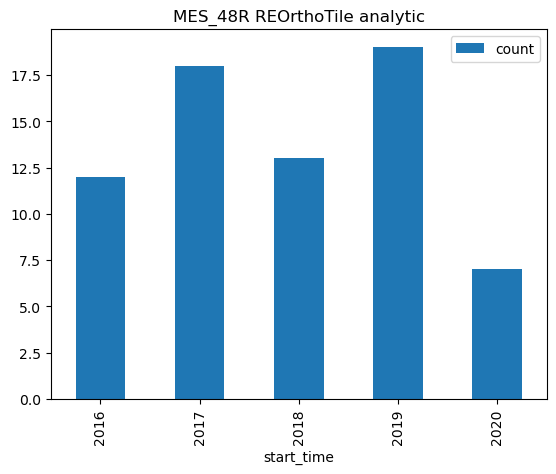

In [112]:
search_results = pd.DataFrame(res_dic['buckets'])
search_results['start_time'] = pd.DatetimeIndex(search_results['start_time']).year
search_results = search_results.set_index('start_time')

search_results.plot(kind = 'bar',title = site_name+" "+str(item_type)+' '+str(asset_filter['config'][0]))
# ~ Ask Patricia about this later
# search_results.plot(kind = 'bar',title = str(item_types)+' '+str(asset_filter['config'][0]))

Requesting

In [99]:
#define the product you want to use from Planet [need to be analytical]

item_type = 'REOrthoTile'

#API request object 
search_request = {
    "item_types" : [ortho_types[1]],
    #"interval" : "day",
    "filter" : combined_filter
}
#send request 
search_result = \
  requests.post(
    'https://api.planet.com/data/v1/quick-search',
    auth=HTTPBasicAuth(API_KEY, ''),
    json=search_request)

geojson = search_result.json() #dont know what this does 
#lets look at the first result 
print(list(geojson.items())[1][1][0])

{'_links': {'_self': 'https://api.planet.com/data/v1/item-types/REOrthoTile/items/20200307_172113_1353907_RapidEye-2', 'assets': 'https://api.planet.com/data/v1/item-types/REOrthoTile/items/20200307_172113_1353907_RapidEye-2/assets/', 'thumbnail': 'https://tiles.planet.com/data/v1/item-types/REOrthoTile/items/20200307_172113_1353907_RapidEye-2/thumb'}, '_permissions': ['assets.analytic:download', 'assets.analytic_sr:download', 'assets.analytic_xml:download', 'assets.udm:download', 'assets.visual:download', 'assets.visual_xml:download'], 'assets': ['analytic', 'analytic_sr', 'analytic_xml', 'udm', 'visual', 'visual_xml'], 'geometry': {'coordinates': [[[-106.8428143494558, 32.086360587179925], [-107.039659, 32.0833958], [-107.044696, 32.3087909], [-106.78495249807202, 32.31272639277787], [-106.8428143494558, 32.086360587179925]]], 'type': 'Polygon'}, 'id': '20200307_172113_1353907_RapidEye-2', 'properties': {'acquired': '2020-03-07T17:21:13Z', 'anomalous_pixels': 0.08, 'black_fill': 0.14

In [100]:
#extract image IDs only 
image_ids = [feature['id'] for feature in geojson['features']]
print(image_ids)
len(image_ids)

['20200307_172113_1353907_RapidEye-2', '20200304_171716_1353907_RapidEye-1', '20200227_171428_1353907_RapidEye-3', '20200125_171745_1353907_RapidEye-2', '20200111_171707_1353907_RapidEye-4', '20200109_171157_1353907_RapidEye-3', '20200106_172615_1353907_RapidEye-1', '20191229_171552_1353907_RapidEye-2', '20191118_172625_1353907_RapidEye-2', '20191110_172142_1353907_RapidEye-2', '20191009_172948_1353907_RapidEye-4', '20190928_173139_1353907_RapidEye-1', '20190705_173226_1353907_RapidEye-1', '20190521_172532_1353907_RapidEye-5', '20190509_173113_1353907_RapidEye-3', '20190428_174417_1353907_RapidEye-2', '20190423_174537_1353907_RapidEye-2', '20190420_173842_1353907_RapidEye-4', '20190408_174511_1353907_RapidEye-2', '20190322_173648_1353907_RapidEye-5', '20190217_173906_1353907_RapidEye-1', '20190216_173536_1353907_RapidEye-5', '20190208_174956_1353907_RapidEye-1', '20190126_173127_1353907_RapidEye-3', '20190124_173546_1353907_RapidEye-1', '20190101_175229_1353907_RapidEye-1', '20181219_1

69

Place Order

In [101]:
orders_url = 'https://api.planet.com/compute/ops/orders/v2'

response = requests.get(orders_url, auth=session.auth)
print(response) #should return 200

#checking if you have orders already created. The list may be empty if you have not created an order yet. 
orders = response.json()['orders']
len(orders)

<Response [200]>


9

Modifying this to add clipping feature

Documentation:
https://support.planet.com/hc/en-us/articles/6075850477213-Example-Payload-for-Using-the-Clip-Tool

In [102]:
todays_date = "09_12_2023" # Change as Applicapable

##### Note 9/12
After numerous exchanges with support and a *lot* of trial and error, the best way to finally place an order is to do one order at a time and not exceed 250 scenes.

In [106]:
#set content type to json 
headers = {'content-type': 'application/json'}

#in the request -- delivery can be changed maybe 
request = {
    "name":(site_name+todays_date+str(ortho_types[1])+"_"+str(minyear)"-"+str(maxyear)+"_order_test"),
    "products":[
        {
            "item_ids":
                image_ids
                # ['20230622_165631_50_24bc'] #just to test the clipping feature
                ,
            'item_type': ortho_types[1],
            "product_bundle": "analytic_sr"

        }
        # ,
        # {
        #     "item_ids":
        #         image_ids
        #         # ['20230622_165631_50_24bc'] #just to test the clipping feature
        #         ,
        #     'item_type': ortho_types[1],
        #     "product_bundle": "analytic_sr"

        # }
    ], 
    "delivery": {
        "single_archive": True, 
        "archive_type": "zip",
        "archive_filename": "{{name}}_{{order_id}}.zip"
        },
    "tools" : [
        {
            "clip": {
                "aoi":study_area
            }
        }
    ]
}

In [108]:
response

<Response [200]>

In [109]:
#Executing the order
order_url = place_order(request, session.auth)

<Response [202]>
c8fd3bdb-c472-45b2-920d-b2d0f2774988


In [32]:
poll_for_success(order_url, session.auth) #when this runs and theres no return that means its ready

running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
success


In [33]:
#view results 
r = requests.get(order_url, auth = session.auth)
response = r.json()
results = response["_links"]['results']
results

[{'delivery': 'success',
  'expires_at': '2023-09-05T22:59:27.811Z',
  'location': 'https://api.planet.com/compute/ops/download/?token=eyJhbGciOiJIUzUxMiIsInR5cCI6IkpXVCJ9.eyJleHAiOjE2OTM5NTQ3NjcsInN1YiI6ImpCdENTaU9XSnBwOHNkbTdQbi9kRTNkdGZCNFNxNGh1TXVkdE5xQWVhMnVxL2pxK3pJOThKSEl6bVhPMGczWk94UGZUaDFwYWsyM3FqRVYwUXFjam1nPT0iLCJ0b2tlbl90eXBlIjoiZG93bmxvYWQtYXNzZXQtc3RhY2siLCJhb2kiOiIiLCJhc3NldHMiOlt7Iml0ZW1fdHlwZSI6IiIsImFzc2V0X3R5cGUiOiIiLCJpdGVtX2lkIjoiIn1dLCJ1cmwiOiJodHRwczovL3N0b3JhZ2UuZ29vZ2xlYXBpcy5jb20vY29tcHV0ZS1vcmRlcnMtbGl2ZS8xZTQzNGViMi1kNjY3LTRlMmEtOGRmZi1hMThiZTQ1OTE4ZjkvTUVTXzQ4UjA5XzA0XzIwMjNfb3JkZXJfdGVzdF8xZTQzNGViMi1kNjY3LTRlMmEtOGRmZi1hMThiZTQ1OTE4ZjkuemlwP1gtR29vZy1BbGdvcml0aG09R09PRzQtUlNBLVNIQTI1Nlx1MDAyNlgtR29vZy1DcmVkZW50aWFsPWNvbXB1dGUtZ2NzLXN2Y2FjYyU0MHBsYW5ldC1jb21wdXRlLXByb2QuaWFtLmdzZXJ2aWNlYWNjb3VudC5jb20lMkYyMDIzMDkwNCUyRmF1dG8lMkZzdG9yYWdlJTJGZ29vZzRfcmVxdWVzdFx1MDAyNlgtR29vZy1EYXRlPTIwMjMwOTA0VDIyNTkyN1pcdTAwMjZYLUdvb2ctRXhwaXJlcz04NjM5OVx1MDAyNlgtR29vZy1T

In [34]:
#download results 
download_results(results)

2 items to download
downloading 1e434eb2-d667-4e2a-8dff-a18be45918f9/MES_48R09_04_2023_order_test_1e434eb2-d667-4e2a-8dff-a18be45918f9.zip to data/1e434eb2-d667-4e2a-8dff-a18be45918f9/MES_48R09_04_2023_order_test_1e434eb2-d667-4e2a-8dff-a18be45918f9.zip
downloading 1e434eb2-d667-4e2a-8dff-a18be45918f9/manifest.json to data/1e434eb2-d667-4e2a-8dff-a18be45918f9/manifest.json


### For downloading old orders

In [6]:
orders_url = 'https://api.planet.com/compute/ops/orders/v2'

response = requests.get(orders_url, auth=session.auth)
print(response) #should return 200

#checking if you have orders already created. The list may be empty if you have not created an order yet. 
orders = response.json()['orders']
len(orders)

<Response [200]>


10

In [13]:
orders

[{'_links': {'_self': 'https://api.planet.com/compute/ops/orders/v2/c8fd3bdb-c472-45b2-920d-b2d0f2774988'},
  'created_on': '2023-09-13T02:30:24.376Z',
  'delivery': {'archive_filename': '{{name}}_{{order_id}}.zip',
   'archive_type': 'zip',
   'single_archive': True},
  'error_hints': [],
  'id': 'c8fd3bdb-c472-45b2-920d-b2d0f2774988',
  'last_message': 'Manifest delivery completed',
  'last_modified': '2023-09-13T04:36:57.904Z',
  'name': 'MES_48R09_12_2023REOrthoTile_2016-2020_order_test',
  'products': [{'item_ids': ['20200307_172113_1353907_RapidEye-2',
     '20200304_171716_1353907_RapidEye-1',
     '20200227_171428_1353907_RapidEye-3',
     '20200125_171745_1353907_RapidEye-2',
     '20200111_171707_1353907_RapidEye-4',
     '20200109_171157_1353907_RapidEye-3',
     '20200106_172615_1353907_RapidEye-1',
     '20191229_171552_1353907_RapidEye-2',
     '20191118_172625_1353907_RapidEye-2',
     '20191110_172142_1353907_RapidEye-2',
     '20191009_172948_1353907_RapidEye-4',
     

In [10]:
# Change the number in the list to see the dictionaries and which specific one(s) you want to download
specific_order = orders[2]
specific_order

{'_links': {'_self': 'https://api.planet.com/compute/ops/orders/v2/b6180667-9363-48b3-8ebd-d2f8e3b32e69'},
 'created_on': '2023-09-05T20:38:45.279Z',
 'delivery': {'archive_filename': '{{name}}_reorthotile_analytic.zip',
  'archive_type': 'zip',
  'single_archive': True},
 'error_hints': [],
 'id': 'b6180667-9363-48b3-8ebd-d2f8e3b32e69',
 'last_message': 'Manifest delivery completed',
 'last_modified': '2023-09-05T22:00:57.464Z',
 'metadata': {'stac': {}},
 'name': 'MES48R_012016through072020_PSREOrthoTile_09052023',
 'notifications': {'email': True},
 'order_type': 'partial',
 'products': [{'item_ids': ['20160111_183905_1353907_RapidEye-3',
    '20160124_183632_1353907_RapidEye-2',
    '20160204_182132_1353907_RapidEye-4',
    '20160210_182921_1353907_RapidEye-5',
    '20160215_183345_1353907_RapidEye-5',
    '20160228_182325_1353907_RapidEye-4',
    '20160302_183315_1353907_RapidEye-2',
    '20160410_182542_1353907_RapidEye-3',
    '20160430_182501_1353907_RapidEye-4',
    '20160606_

Copy that order id listed above and paste below or reference it directly from the nested dictionaries

In [49]:
order_url_test = specific_order['id']
print(specific_order['name'],':')
print(order_url_test)

MES_48R09_04_2023_order_test :
1e434eb2-d667-4e2a-8dff-a18be45918f9


In [50]:
order_id = specific_order['id']
order_name = specific_order['name']
order_url = orders_url + '/' + order_id
print('Name: ',order_name)
print('URL:',order_url)
poll_for_success(order_url, session.auth) #when this runs and theres no return that means its ready

Name:  MES_48R09_04_2023_order_test
URL: https://api.planet.com/compute/ops/orders/v2/1e434eb2-d667-4e2a-8dff-a18be45918f9
success


In [51]:
#view results 
r = requests.get(order_url, auth = session.auth)
response = r.json()
results = response["_links"]['results']
results

[{'delivery': 'success',
  'expires_at': '2023-09-05T23:41:54.623Z',
  'location': 'https://api.planet.com/compute/ops/download/?token=eyJhbGciOiJIUzUxMiIsInR5cCI6IkpXVCJ9.eyJleHAiOjE2OTM5NTczMTQsInN1YiI6InlQVkNyazdIUEsydTlxSUNDMjRKc2xwWWtydHVHSjlhcnVLZUlvZDJjbE9Jblp3S2xZUVlHYWZ3NGtzNUQrNk52MnNzMG02cGh0eGMrYy9SOStjN2ZBPT0iLCJ0b2tlbl90eXBlIjoiZG93bmxvYWQtYXNzZXQtc3RhY2siLCJhb2kiOiIiLCJhc3NldHMiOlt7Iml0ZW1fdHlwZSI6IiIsImFzc2V0X3R5cGUiOiIiLCJpdGVtX2lkIjoiIn1dLCJ1cmwiOiJodHRwczovL3N0b3JhZ2UuZ29vZ2xlYXBpcy5jb20vY29tcHV0ZS1vcmRlcnMtbGl2ZS8xZTQzNGViMi1kNjY3LTRlMmEtOGRmZi1hMThiZTQ1OTE4ZjkvTUVTXzQ4UjA5XzA0XzIwMjNfb3JkZXJfdGVzdF8xZTQzNGViMi1kNjY3LTRlMmEtOGRmZi1hMThiZTQ1OTE4ZjkuemlwP1gtR29vZy1BbGdvcml0aG09R09PRzQtUlNBLVNIQTI1Nlx1MDAyNlgtR29vZy1DcmVkZW50aWFsPWNvbXB1dGUtZ2NzLXN2Y2FjYyU0MHBsYW5ldC1jb21wdXRlLXByb2QuaWFtLmdzZXJ2aWNlYWNjb3VudC5jb20lMkYyMDIzMDkwNCUyRmF1dG8lMkZzdG9yYWdlJTJGZ29vZzRfcmVxdWVzdFx1MDAyNlgtR29vZy1EYXRlPTIwMjMwOTA0VDIzNDE1NFpcdTAwMjZYLUdvb2ctRXhwaXJlcz04NjM5OVx1MDAyNlgtR29vZy1T

In [239]:
#download results 
download_results(results)

2 items to download
downloading abf49b75-df4e-42f0-8f7b-4d61f3c2e54e/lake_mead_06-19-23_order_abf49b75-df4e-42f0-8f7b-4d61f3c2e54e.zip to data/abf49b75-df4e-42f0-8f7b-4d61f3c2e54e/lake_mead_06-19-23_order_abf49b75-df4e-42f0-8f7b-4d61f3c2e54e.zip
downloading abf49b75-df4e-42f0-8f7b-4d61f3c2e54e/manifest.json to data/abf49b75-df4e-42f0-8f7b-4d61f3c2e54e/manifest.json


For Loop to download multiple orders

In [12]:
ordernums = [0,1]
for i in ordernums:
    specific_order = orders[i]
    order_id = specific_order['id']
    order_name = specific_order['name']
    order_url = orders_url + '/' + order_id
    print('Name: ',order_name)
    print('URL:',order_url)
    poll_for_success(order_url, session.auth)
    #view results 
    r = requests.get(order_url, auth = session.auth)
    response = r.json()
    results = response["_links"]['results']
    results
    download_results(results)
    print("Download "+str(i)+" complete.")

Name:  MES_48R09_12_2023REOrthoTile_2016-2020_order_test
URL: https://api.planet.com/compute/ops/orders/v2/c8fd3bdb-c472-45b2-920d-b2d0f2774988
success
2 items to download
downloading c8fd3bdb-c472-45b2-920d-b2d0f2774988/MES_48R09_12_2023REOrthoTile_2016-2020_order_test_c8fd3bdb-c472-45b2-920d-b2d0f2774988.zip to data\c8fd3bdb-c472-45b2-920d-b2d0f2774988\MES_48R09_12_2023REOrthoTile_2016-2020_order_test_c8fd3bdb-c472-45b2-920d-b2d0f2774988.zip
downloading c8fd3bdb-c472-45b2-920d-b2d0f2774988/manifest.json to data\c8fd3bdb-c472-45b2-920d-b2d0f2774988\manifest.json
Download 0 complete.
Name:  MES_48R09_12_2023PSOrthoTile_2016-2020_order_test
URL: https://api.planet.com/compute/ops/orders/v2/00e22f98-edf0-4d17-a8f2-67daf2acc613
success
2 items to download
downloading 00e22f98-edf0-4d17-a8f2-67daf2acc613/MES_48R09_12_2023PSOrthoTile_2016-2020_order_test_00e22f98-edf0-4d17-a8f2-67daf2acc613.zip to data\00e22f98-edf0-4d17-a8f2-67daf2acc613\MES_48R09_12_2023PSOrthoTile_2016-2020_order_test_00

Unzipping and moving the files to the data folder

In [14]:
import zipfile

for i in ordernums:
    specific_order = orders[i]
    order_id = specific_order['id']
    order_name = specific_order['name']
    path_to_zip_file = 'Data/'+order_id+"/"+order_name+"_"+order_id+'.zip'
    directory_to_extract_to = './Data/MES_48R'
    print(path_to_zip_file)
    with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
       zip_ref.extractall(directory_to_extract_to)

Data/c8fd3bdb-c472-45b2-920d-b2d0f2774988/MES_48R09_12_2023REOrthoTile_2016-2020_order_test_c8fd3bdb-c472-45b2-920d-b2d0f2774988.zip
Data/00e22f98-edf0-4d17-a8f2-67daf2acc613/MES_48R09_12_2023PSOrthoTile_2016-2020_order_test_00e22f98-edf0-4d17-a8f2-67daf2acc613.zip


### Mosaicing

In [15]:
# Get meta data on the raster images
# !gdalinfo ~/Documents/PhD_Materials/github_repos/Tadych_PlanetData_Challenge/Data/RapidEye/1354105_2010-03-25_RE5_3A_Analytic_SR_clip.tif

Driver: GTiff/GeoTIFF
Files: /Users/danielletadych/Documents/PhD_Materials/github_repos/Tadych_PlanetData_Challenge/Data/RapidEye/1354105_2010-03-25_RE5_3A_Analytic_SR_clip.tif
       /Users/danielletadych/Documents/PhD_Materials/github_repos/Tadych_PlanetData_Challenge/Data/RapidEye/1354105_2010-03-25_RE5_3A_Analytic_SR_clip.tif.aux.xml
Size is 248, 309
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 13N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 13N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-105,
            ANGLEUNIT["degree

##### Show all the downloaded Rapid Eye files

In [202]:
# ls Data/RapidEye/*RE*_3A_Analytic_SR_clip.tif

##### Show all the downloaded Planet Scope files

In [203]:
# ls Data/PlanetScope/*SR_clip.tif

In [206]:
# for i in years:
#     year = str(i)
#     for j in months:
#         # month = str(j)
#         month = format(j, '02')
#         for k in days:
#             day = format(k, '02')
#             print(year+"-"+month+"-"+day)

In [204]:

# ls -1 Data/RapidEye/*RE*_3A_Analytic_SR_clip.tif > tiff_test_list.txt


In [205]:
items = glob.glob('Data/RapidEye/*2010*RE*_3A_Analytic_SR_clip.tif')
items

In [50]:
# Getting the date ranges
years = range(2010,2018)
months = range(1,13)
days = range(0,32)

# Use this to make it stop printing that there aren't images available
gdal.PushErrorHandler('CPLQuietErrorHandler')

# Mosaicing for loop for Rapid Eye
for i in years:
    year = str(i)
    for j in months:
        # month = str(j)
        month = format(j, '02')
        for k in days:
            day = format(k, '02')
            # print(year+"-"+month+"-"+day) #Un-comment this if you want to see which days hve errors
            monthly_files_list = glob.glob('Data/RapidEye/*'+year+"-"+month+"-"+day+'*_3A_Analytic_SR_clip.tif')
            # This code was for writing all the files into a text file
            # with open(year+'-'+month+'_tif_list.txt', 'w') as f:
            #     for line in items:
            #         f.write(line)
            #         f.write('\n')
            files_to_mosaic = monthly_files_list # However many you want.
            g = gdal.Warp('outputfiles/mosaic_'+year+'-'+month+"-"+day+'.tif', files_to_mosaic, format="GTiff",
                  options=["COMPRESS=LZW", "TILED=YES"]) # if you want
            g = None # Close file and flush to disk
            # !gdal_merge.py -n 0 -v -o 'mosaic_year'+'-'+month+'_test.tif' --optfile year+'-'+month+'2010_tif_list.txt'
    print('Finished for ',year)

Finished for  2010
Finished for  2011
Finished for  2012
Finished for  2013
Finished for  2014
Finished for  2015
Finished for  2016
Finished for  2017


In [51]:
gdal.PushErrorHandler('CPLQuietErrorHandler')
# Mosaicing for loop for PlanetScope SR
for i in years:
    year = str(i)
    for j in months:
        # month = str(j)
        month = format(j, '02')
        for k in days:
            day = format(k, '02')
            # print(year+"-"+month+"-"+day)
            monthly_files_list = glob.glob('Data/PlanetScope/*'+year+"-"+month+"-"+day+'*RE*_3A_Analytic_SR_clip.tif')
            # This code was for writing all the files into a text file
            # with open(year+'-'+month+'_tif_list.txt', 'w') as f:
            #     for line in items:
            #         f.write(line)
            #         f.write('\n')
            files_to_mosaic = monthly_files_list # However many you want.
            g = gdal.Warp('outputfiles/mosaic_'+year+'-'+month+"-"+day+'.tif', files_to_mosaic, format="GTiff",
                  options=["COMPRESS=LZW", "TILED=YES"]) # if you want
            g = None # Close file and flush to disk
            # !gdal_merge.py -n 0 -v -o 'mosaic_year'+'-'+month+'_test.tif' --optfile year+'-'+month+'2010_tif_list.txt'
    print('finished for ',year)

2010-01-00
2010-01-01
2010-01-02
2010-01-03
2010-01-04
2010-01-05
2010-01-06
2010-01-07
2010-01-08
2010-01-09
2010-01-10
2010-01-11
2010-01-12
2010-01-13
2010-01-14
2010-01-15
2010-01-16
2010-01-17
2010-01-18
2010-01-19
2010-01-20
2010-01-21
2010-01-22
2010-01-23
2010-01-24
2010-01-25
2010-01-26
2010-01-27
2010-01-28
2010-01-29
2010-01-30
2010-01-31
2010-02-00
2010-02-01
2010-02-02
2010-02-03
2010-02-04
2010-02-05
2010-02-06
2010-02-07
2010-02-08
2010-02-09
2010-02-10
2010-02-11
2010-02-12
2010-02-13
2010-02-14
2010-02-15
2010-02-16
2010-02-17
2010-02-18
2010-02-19
2010-02-20
2010-02-21
2010-02-22
2010-02-23
2010-02-24
2010-02-25
2010-02-26
2010-02-27
2010-02-28
2010-02-29
2010-02-30
2010-02-31
2010-03-00
2010-03-01
2010-03-02
2010-03-03
2010-03-04
2010-03-05
2010-03-06
2010-03-07
2010-03-08
2010-03-09
2010-03-10
2010-03-11
2010-03-12
2010-03-13
2010-03-14
2010-03-15
2010-03-16
2010-03-17
2010-03-18
2010-03-19
2010-03-20
2010-03-21
2010-03-22
2010-03-23
2010-03-24
2010-03-25
2010-03-26

In [39]:
# !gdal_merge.py -n 0 -v -o mosaic_test.tif --optfile tiff_test_list.txt
!gdal_merge.py -n 0 -v -o mosaic_2010_test.tif --optfile 2010_tif_list.txt


Processing file     1 of    21,  0.000% completed in 0 minutes.
Filename: Data/RapidEye/1354206_2010-10-27_RE1_3A_Analytic_SR_clip.tif
File Size: 1808x5041x5
Pixel Size: 5.000000 x -5.000000
UL:(283415.000000,3648600.000000)   LR:(292455.000000,3623395.000000)
Copy 0,0,1808,5041 to 543,387,1808,5041.
Copy 0,0,1808,5041 to 543,387,1808,5041.
Copy 0,0,1808,5041 to 543,387,1808,5041.
Copy 0,0,1808,5041 to 543,387,1808,5041.
Copy 0,0,1808,5041 to 543,387,1808,5041.

Processing file     2 of    21,  4.762% completed in 0 minutes.
Filename: Data/RapidEye/1354107_2010-03-25_RE5_3A_Analytic_SR_clip.tif
File Size: 1641x2739x5
Pixel Size: 5.000000 x -5.000000
UL:(307415.000000,3617120.000000)   LR:(315620.000000,3603425.000000)
Copy 0,0,1641,2739 to 5343,6683,1641,2739.
Copy 0,0,1641,2739 to 5343,6683,1641,2739.
Copy 0,0,1641,2739 to 5343,6683,1641,2739.
Copy 0,0,1641,2739 to 5343,6683,1641,2739.
Copy 0,0,1641,2739 to 5343,6683,1641,2739.

Processing file     3 of    21,  9.524% completed in 0 

In [28]:
os.remove("tiff_test_list.txt")

In [ ]:
# this helps merge files
!gdal_merge.py -v Data/RapidEye/1354105_2013-05-19_RE2_3A_Analytic_SR_clip.tif Data/RapidEye/1354106_2013-05-19_RE2_3A_Analytic_SR_clip.tif Data/RapidEye/1354107_2013-05-19_RE2_3A_Analytic_SR_clip.tif  Data/RapidEye/1354205_2013-05-19_RE2_3A_Analytic_SR_clip.tif Data/RapidEye/1354206_2013-05-19_RE2_3A_Analytic_SR_clip.tif Data/RapidEye/1354305_2013-05-19_RE2_3A_Analytic_SR_clip.tif Data/RapidEye/1354306_2013-05-19_RE2_3A_Analytic_SR_clip.tif -o 2013-05-19_merged.tif


Processing file     1 of     7,  0.000% completed in 0 minutes.
Filename: Data/RapidEye/1354105_2013-05-19_RE2_3A_Analytic_SR_clip.tif
File Size: 248x309x5
Pixel Size: 5.000000 x -5.000000
UL:(283345.000000,3624600.000000)   LR:(284585.000000,3623055.000000)
Copy 0,0,248,309 to 529,5187,248,309.
Copy 0,0,248,309 to 529,5187,248,309.
Copy 0,0,248,309 to 529,5187,248,309.
Copy 0,0,248,309 to 529,5187,248,309.
Copy 0,0,248,309 to 529,5187,248,309.

Processing file     2 of     7, 14.286% completed in 0 minutes.
Filename: Data/RapidEye/1354106_2013-05-19_RE2_3A_Analytic_SR_clip.tif
File Size: 5034x3324x5
Pixel Size: 5.000000 x -5.000000
UL:(283415.000000,3624600.000000)   LR:(308585.000000,3607980.000000)
Copy 0,0,5034,3324 to 543,5187,5034,3324.
Copy 0,0,5034,3324 to 543,5187,5034,3324.
Copy 0,0,5034,3324 to 543,5187,5034,3324.
Copy 0,0,5034,3324 to 543,5187,5034,3324.
Copy 0,0,5034,3324 to 543,5187,5034,3324.

Processing file     3 of     7, 28.571% completed in 0 minutes.
Filename: Dat

### Extract the data from the red and near-infrared bands 

In [2]:
import rasterio
import numpy as np

filepath = "outputfiles/"
outputpath = 'outputfiles/ndvi/'
# filename = "data/20160831_180302_0e26_3B_AnalyticMS_SR.tif"
# filename = filepath+"1354107_2013-05-19_RE2_3A_Analytic_SR_clip.tif"
# filename = '2013-05-19_merged.tif'
filename = 'mosaic_2010-03-25.tif'

# Load red and NIR bands - note all PlanetScope 4-band images have band order BGRN
with rasterio.open(filepath+filename) as src:
    band_red = src.read(3)

with rasterio.open(filepath+filename) as src:
    band_nir = src.read(4)

### Perform the NDVI calculation

Next, you're going to calculate NDVI through subtraction and division of the values stored in the NumPy arrays. This calculation will give you NDVI values that range from -1 to 1. Values closer to 1 indicate a greater density of vegetation or higher level of "greenness."

In [54]:
# Allow division by zero
np.seterr(divide='ignore', invalid='ignore')

# Calculate NDVI. This is the equation at the top of this guide expressed in code
ndvi = (band_nir.astype(float) - band_red.astype(float)) / (band_nir + band_red)

In [55]:
# check range NDVI values, excluding NaN
np.nanmin(ndvi), np.nanmax(ndvi)

(-0.2560877709392561, 0.6313497822931785)

### Save an NDVI image 

Next, you're going to save the calculated NDVI values to a new image file, making sure the new image file has the same geospatial metadata as the original GeoTIFF we downloaded.

In [56]:
# Set spatial characteristics of the output object to mirror the input
kwargs = src.meta
kwargs.update(
    dtype=rasterio.float32,
    count = 1)

# Write band calculations to a new raster file
with rasterio.open(outputpath+filename+'_ndvi.tif', 'w', **kwargs) as dst:
        dst.write_band(1, ndvi.astype(rasterio.float32))

In [3]:
items = glob.glob('outputfiles/*.tif')
items.sort()
items

['outputfiles/mosaic_2010-03-25.tif',
 'outputfiles/mosaic_2010-10-27.tif',
 'outputfiles/mosaic_2010-12-09.tif',
 'outputfiles/mosaic_2012-02-15.tif',
 'outputfiles/mosaic_2012-10-17.tif',
 'outputfiles/mosaic_2013-01-13.tif',
 'outputfiles/mosaic_2013-02-01.tif',
 'outputfiles/mosaic_2013-05-19.tif',
 'outputfiles/mosaic_2013-05-20.tif',
 'outputfiles/mosaic_2013-10-03.tif',
 'outputfiles/mosaic_2013-11-02.tif',
 'outputfiles/mosaic_2013-12-01.tif',
 'outputfiles/mosaic_2013-12-17.tif',
 'outputfiles/mosaic_2014-01-03.tif',
 'outputfiles/mosaic_2014-03-21.tif',
 'outputfiles/mosaic_2014-03-22.tif',
 'outputfiles/mosaic_2014-07-26.tif',
 'outputfiles/mosaic_2014-10-12.tif',
 'outputfiles/mosaic_2015-04-14.tif',
 'outputfiles/mosaic_2016-01-11.tif',
 'outputfiles/mosaic_2016-02-04.tif',
 'outputfiles/mosaic_2016-04-14.tif',
 'outputfiles/mosaic_2016-06-10.tif',
 'outputfiles/mosaic_2016-06-14.tif',
 'outputfiles/mosaic_2017-01-04.tif',
 'outputfiles/mosaic_2017-02-23.tif',
 'outputfile

In [13]:
years = range(2010,2018)
for y in years:
    year = str(y)
    yearcount = glob.glob('outputfiles/*'+year+'*.tif')
    print(year,':',len(yearcount))

2010 : 3
2011 : 0
2012 : 2
2013 : 8
2014 : 5
2015 : 1
2016 : 5
2017 : 6


In [6]:
# For loop to standardize this

for i in items:
    mosaic = i
    # Load red and NIR bands - note all PlanetScope 4-band images have band order BGRN
    with rasterio.open(mosaic) as src:
        band_red = src.read(3)
    with rasterio.open(mosaic) as src:
        band_nir = src.read(4)
    # Allow division by zero
    np.seterr(divide='ignore', invalid='ignore')
    # Calculate NDVI. This is the equation at the top of this guide expressed in code
    ndvi = (band_nir.astype(float) - band_red.astype(float)) / (band_nir + band_red)# check range NDVI values, excluding NaN
    np.nanmin(ndvi), np.nanmax(ndvi)
    # Set spatial characteristics of the output object to mirror the input
    kwargs = src.meta
    kwargs.update(
        dtype=rasterio.float32,
        count = 1)

    # Write band calculations to a new raster file
    with rasterio.open(mosaic+'_ndvi.tif', 'w', **kwargs) as dst:
            dst.write_band(1, ndvi.astype(rasterio.float32))

print("NDVI files exported.")

NDVI files exported.


### Visualize the NDVI values on the image

In the last two steps, you'll use [Matplotlib](https://matplotlib.org/) to visualize the NDVI values you calculated for the PlanetScope scene. First you'll view a map of the NDVI values; then you'll generate a histogram of NDVI values. 

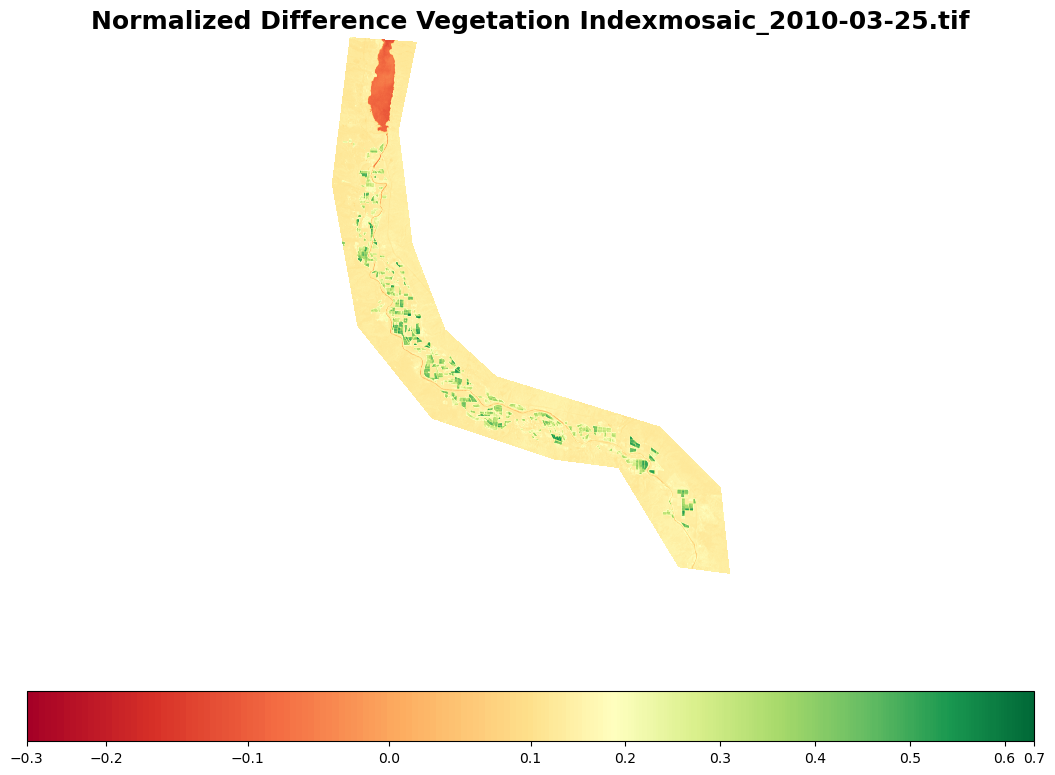

In [57]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

"""
The NDVI values will range from -1 to 1. You want to use a diverging color scheme to visualize the data,
and you want to center the colorbar at a defined midpoint. The class below allows you to normalize the colorbar.
"""

class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)
    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    Credit: Joe Kington, http://chris35wills.github.io/matplotlib_diverging_colorbar/
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))


# Set min/max values from NDVI range for image (excluding NAN)
# set midpoint according to how NDVI is interpreted: https://earthobservatory.nasa.gov/Features/MeasuringVegetation/
min=np.nanmin(ndvi)
max=np.nanmax(ndvi)
mid=0.1

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

# diverging color scheme chosen from https://matplotlib.org/users/colormaps.html
cmap = plt.cm.RdYlGn 

cax = ax.imshow(ndvi, cmap=cmap, clim=(min, max), norm=MidpointNormalize(midpoint=mid,vmin=min, vmax=max))

ax.axis('off')
ax.set_title('Normalized Difference Vegetation Index'+str(filename), fontsize=18, fontweight='bold')

cbar = fig.colorbar(cax, orientation='horizontal', shrink=0.65)

fig.savefig(outputpath+filename+"ndvi-fig.png", dpi=200, bbox_inches='tight', pad_inches=0.7)

plt.show()

### Generate a histogram of NDVI values

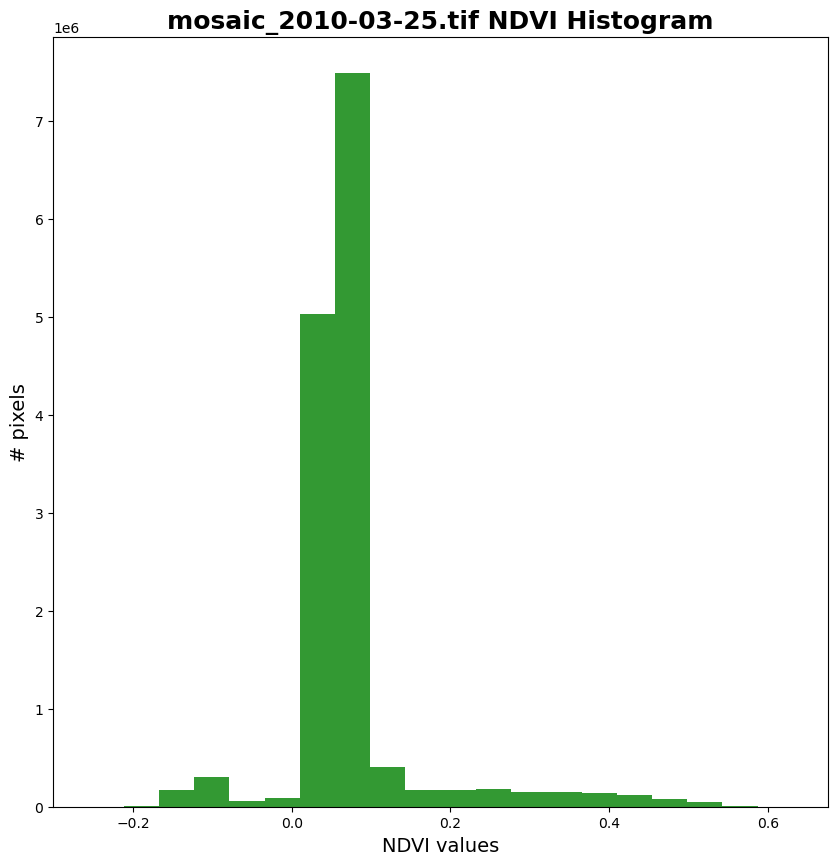

In [58]:
fig2 = plt.figure(figsize=(10,10))
ax = fig2.add_subplot(111)

plt.title(str(filename)+" NDVI Histogram", fontsize=18, fontweight='bold')
plt.xlabel("NDVI values", fontsize=14)
plt.ylabel("# pixels", fontsize=14)


x = ndvi[~np.isnan(ndvi)]
numBins = 20
ax.hist(x,numBins,color='green',alpha=0.8)

fig2.savefig(outputpath+filename+" ndvi-histogram.png", dpi=200, bbox_inches='tight', pad_inches=0.7)

plt.show()

## Special Rio Grande Analysis

In [5]:
# Grab out dates
items = glob.glob('outputfiles/*.tif')
items

['outputfiles/mosaic_2014-01-03.tif',
 'outputfiles/mosaic_2016-02-04.tif',
 'outputfiles/mosaic_2010-03-25.tif',
 'outputfiles/mosaic_2017-05-20.tif',
 'outputfiles/mosaic_2016-06-10.tif',
 'outputfiles/mosaic_2016-04-14.tif',
 'outputfiles/mosaic_2013-01-13.tif',
 'outputfiles/mosaic_2013-11-02.tif',
 'outputfiles/mosaic_2016-06-14.tif',
 'outputfiles/mosaic_2017-10-08.tif',
 'outputfiles/mosaic_2015-04-14.tif',
 'outputfiles/mosaic_2014-07-26.tif',
 'outputfiles/mosaic_2016-01-11.tif',
 'outputfiles/mosaic_2017-02-23.tif',
 'outputfiles/mosaic_2012-02-15.tif',
 'outputfiles/mosaic_2014-10-12.tif',
 'outputfiles/mosaic_2012-10-17.tif',
 'outputfiles/mosaic_2017-10-25.tif',
 'outputfiles/mosaic_2013-12-17.tif',
 'outputfiles/mosaic_2014-03-22.tif',
 'outputfiles/mosaic_2010-10-27.tif',
 'outputfiles/mosaic_2017-01-04.tif',
 'outputfiles/mosaic_2014-03-21.tif',
 'outputfiles/mosaic_2013-05-19.tif',
 'outputfiles/mosaic_2010-12-09.tif',
 'outputfiles/mosaic_2013-12-01.tif',
 'outputfile

In [6]:
# Read in the Shapefile
filename = "DataChallenge_Mask_Reprojected.shp"
filepath = os.path.join('Data/Shapefiles/', filename)
study_areas = gp.read_file(filepath)

In [7]:
date_list = []
for i in items:
    date = i[-14:-4]
    parsed_date = datetime.datetime.strptime(date, "%Y-%m-%d")
    date_list.append(parsed_date)
dt_array = np.array(date_list, dtype='datetime64')
dt_array.sort()

In [8]:
dt_array

array(['2010-03-25T00:00:00.000000', '2010-10-27T00:00:00.000000',
       '2010-12-09T00:00:00.000000', '2012-02-15T00:00:00.000000',
       '2012-10-17T00:00:00.000000', '2013-01-13T00:00:00.000000',
       '2013-02-01T00:00:00.000000', '2013-05-19T00:00:00.000000',
       '2013-05-20T00:00:00.000000', '2013-10-03T00:00:00.000000',
       '2013-11-02T00:00:00.000000', '2013-12-01T00:00:00.000000',
       '2013-12-17T00:00:00.000000', '2014-01-03T00:00:00.000000',
       '2014-03-21T00:00:00.000000', '2014-03-22T00:00:00.000000',
       '2014-07-26T00:00:00.000000', '2014-10-12T00:00:00.000000',
       '2015-04-14T00:00:00.000000', '2016-01-11T00:00:00.000000',
       '2016-02-04T00:00:00.000000', '2016-04-14T00:00:00.000000',
       '2016-06-10T00:00:00.000000', '2016-06-14T00:00:00.000000',
       '2017-01-04T00:00:00.000000', '2017-02-23T00:00:00.000000',
       '2017-05-20T00:00:00.000000', '2017-10-08T00:00:00.000000',
       '2017-10-25T00:00:00.000000', '2017-11-10T00:00:00.0000

In [9]:
# Open in xarray

ndvi_tifs = glob.glob('outputfiles/ndvi/*.tif')
ndvi_tifs.sort()
ndvi_tifs

['outputfiles/ndvi/mosaic_2010-03-25.tif_ndvi.tif',
 'outputfiles/ndvi/mosaic_2010-10-27.tif_ndvi.tif',
 'outputfiles/ndvi/mosaic_2010-12-09.tif_ndvi.tif',
 'outputfiles/ndvi/mosaic_2012-02-15.tif_ndvi.tif',
 'outputfiles/ndvi/mosaic_2012-10-17.tif_ndvi.tif',
 'outputfiles/ndvi/mosaic_2013-01-13.tif_ndvi.tif',
 'outputfiles/ndvi/mosaic_2013-02-01.tif_ndvi.tif',
 'outputfiles/ndvi/mosaic_2013-05-19.tif_ndvi.tif',
 'outputfiles/ndvi/mosaic_2013-05-20.tif_ndvi.tif',
 'outputfiles/ndvi/mosaic_2013-10-03.tif_ndvi.tif',
 'outputfiles/ndvi/mosaic_2013-11-02.tif_ndvi.tif',
 'outputfiles/ndvi/mosaic_2013-12-01.tif_ndvi.tif',
 'outputfiles/ndvi/mosaic_2013-12-17.tif_ndvi.tif',
 'outputfiles/ndvi/mosaic_2014-01-03.tif_ndvi.tif',
 'outputfiles/ndvi/mosaic_2014-03-21.tif_ndvi.tif',
 'outputfiles/ndvi/mosaic_2014-03-22.tif_ndvi.tif',
 'outputfiles/ndvi/mosaic_2014-07-26.tif_ndvi.tif',
 'outputfiles/ndvi/mosaic_2014-10-12.tif_ndvi.tif',
 'outputfiles/ndvi/mosaic_2015-04-14.tif_ndvi.tif',
 'outputfile

In [10]:
# Testing to see if coordinate systems match
ndvi_file_toclip = xr.open_dataset(ndvi_tifs[17])
mask = study_areas
print("mask crs:", mask.crs)
print("data crs:", ndvi_file_toclip.rio.crs)

mask crs: EPSG:32612
data crs: EPSG:32613


In [11]:
# Skip this if they are both in the same coordinate system and change info in next cell
mask_reproject = mask.to_crs(epsg=32613)
print("mask crs:", mask_reproject.crs)

mask crs: EPSG:32613


In [12]:
# Clipping
clipped = ndvi_file_toclip.rio.clip(mask_reproject.geometry, mask_reproject.crs)
# clipped.plot()

In [13]:
clipped_np = clipped['band_data'].to_numpy()
clipped_np.shape

(1, 3160, 4990)

In [14]:
ndvi_file_1 = xr.open_dataset(ndvi_tifs[0])
# ndvi_file['band_data']
ndvi_data_1 = ndvi_file_1['band_data']
ndvi_array_1 = ndvi_data_1.to_numpy()

all_data = []
for i in ndvi_tifs:
    ndvi_file = xr.open_dataset(i)
    clipped = ndvi_file.rio.clip(mask_reproject.geometry, mask_reproject.crs)
    ndvi_data = clipped['band_data']
    ndvi_array = ndvi_data.to_numpy()
    # # dummy_array = np.ndarray(shape=ndvi_array_1,dtype=float)
    # # ndvi_array.read.direct(dummy_array)
    # # np.place(dummy_array, dummy_array==ndvi_array.attrs.get('_FillValue'),np.nan)
    # ndvi_array=np.ndarray(shape=ndvi_data.shape,dtype=float)
    # ndvi_data.read_direct(ndvi_array)
    # np.place(ndvi_array,ndvi_array==ndvi_data.attrs.get('_FillValue'), np.nan)
    all_data.append(ndvi_array)
    print(ndvi_array.shape)
    # all_data.append(ndvi_file)
# all_data

(1, 3160, 4990)
(1, 3160, 4990)
(1, 3160, 4990)
(1, 3160, 4990)
(1, 3160, 4990)
(1, 3160, 4990)
(1, 3160, 4990)
(1, 3160, 4990)
(1, 3160, 4990)
(1, 3160, 4990)
(1, 3160, 4990)
(1, 3160, 4990)
(1, 3160, 4990)
(1, 3160, 4990)
(1, 3160, 4990)
(1, 3160, 4990)
(1, 3160, 4990)
(1, 3160, 4990)
(1, 3160, 4990)
(1, 3160, 4990)
(1, 3160, 4990)
(1, 3160, 4990)
(1, 3160, 4990)
(1, 3160, 4990)
(1, 3160, 4990)
(1, 3160, 4990)
(1, 3160, 4990)
(1, 3160, 4990)
(1, 3160, 4990)
(1, 3160, 4990)


In [15]:
combo = np.vstack(all_data)
combo.shape

(30, 3160, 4990)

In [16]:
combo

array([[[0.06839687, 0.07827039, 0.07583418, ...,        nan,
                nan,        nan],
        [0.07864597, 0.05376344, 0.06229661, ...,        nan,
                nan,        nan],
        [0.04583439, 0.01787394, 0.05179795, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ..., 0.12614259,
         0.10476191, 0.04962153],
        [       nan,        nan,        nan, ..., 0.11536748,
         0.08584905, 0.05160744],
        [       nan,        nan,        nan, ..., 0.09662751,
         0.12414109, 0.07085916]],

       [[0.21866295, 0.2521861 , 0.20318726, ...,        nan,
                nan,        nan],
        [0.18223584, 0.20993087, 0.17650676, ...,        nan,
                nan,        nan],
        [0.14185022, 0.16591929, 0.16630669, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ..., 0.38183933,
         0.30962098, 0.18342541],
        [   

In [17]:
lat_main = clipped['x']
lon_main = clipped['y']

lon_main = lon_main.to_numpy()
lat_main = lat_main.to_numpy()
# lat_main

In [18]:
print("Main data shape: ", combo.shape)
print('Longitude shape: ', lon_main.shape)
print("Latitude shape: ", lat_main.shape)
print('Data Shape: ', dt_array.shape)

Main data shape:  (30, 3160, 4990)
Longitude shape:  (3160,)
Latitude shape:  (4990,)
Data Shape:  (30,)


In [19]:
data_xr = xr.DataArray(
    combo,
    coords={'time':dt_array,'lon': lon_main,'lat': lat_main}, 
    dims=["time","lon", "lat"],
    attrs=dict(
        description="Calculated NDVI")
)
data_xr

<xarray.DataArray (time: 30, lon: 3160, lat: 4990)>
array([[[0.06839687, 0.07827039, 0.07583418, ...,        nan,
                nan,        nan],
        [0.07864597, 0.05376344, 0.06229661, ...,        nan,
                nan,        nan],
        [0.04583439, 0.01787394, 0.05179795, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ..., 0.12614259,
         0.10476191, 0.04962153],
        [       nan,        nan,        nan, ..., 0.11536748,
         0.08584905, 0.05160744],
        [       nan,        nan,        nan, ..., 0.09662751,
         0.12414109, 0.07085916]],

       [[0.21866295, 0.2521861 , 0.20318726, ...,        nan,
                nan,        nan],
        [0.18223584, 0.20993087, 0.17650676, ...,        nan,
                nan,        nan],
        [0.14185022, 0.16591929, 0.16630669, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ..., 0.19244823,
         0.09968521, 0.01830443],
        [       nan,        nan,        nan, ..., 0.28103682,
         0.16470589, 0.07775965],
        [       nan,        nan,        nan, ..., 0.2570481 ,
         0.11673469, 0.08883554]],

       [[0.13654473, 0.10951526, 0.05664264, ...,        nan,
                nan,        nan],
        [0.06841612, 0.08756039, 0.07059477, ...,        nan,
                nan,        nan],
        [0.03472222, 0.07624795, 0.07847478, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ..., 0.25353926,
         0.17713568, 0.08290452],
        [       nan,        nan,        nan, ..., 0.24761905,
         0.21157822, 0.16733068],
        [       nan,        nan,        nan, ..., 0.29340512,
         0.2766252 , 0.24931507]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2010-03-25 2010-10-27 ... 2017-11-10
  * lon      (lon) float64 3.627e+06 3.627e+06 3.627e+06 ... 3.611e+06 3.611e+06
  * lat      (lat) float64 2.854e+05 2.854e+05 2.854e+05 ... 3.104e+05 3.104e+05
Attributes:
    description:  Calculated NDVI

In [31]:
data_xr2 = data_xr.rio.set_spatial_dims('lat','lon')
data_xr2.rio.to_raster(r"NDVI_time_attempt2.nc")

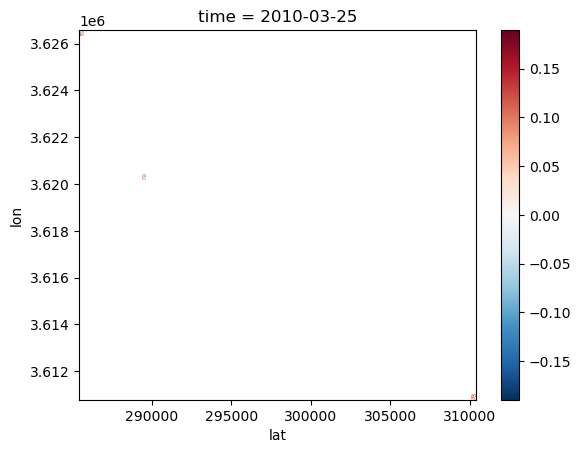

In [33]:
data_xr2[0,:,:].plot()

## Timeseries

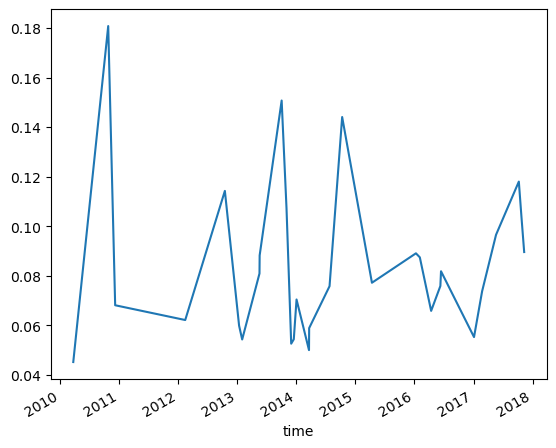

In [34]:
# Study area mean
NDVI_ts = data_xr2.mean(('lon','lat'))
NDVI_ts.plot()

In [68]:
NDVI_ts_df = NDVI_ts.to_dataframe(name='NDVI')
NDVI_ts_df['Year'] = pd.DatetimeIndex(NDVI_ts_df.index).year
NDVI_ts_df

,NDVI,Year
time,,
2010-03-25,0.045241,2010
2010-10-27,0.180760,2010
2010-12-09,0.068149,2010
2012-02-15,0.062190,2012
2012-10-17,0.114276,2012
2013-01-13,0.059894,2013
2013-02-01,0.054340,2013
2013-05-19,0.080961,2013
2013-05-20,0.088244,2013


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'NDVI (-1 to 1)')

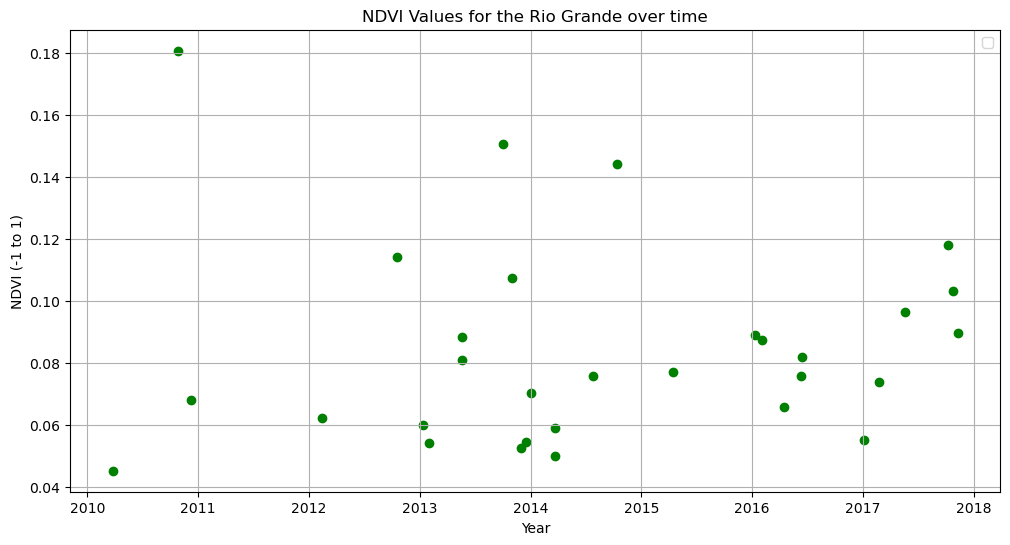

In [46]:
f, ax = plt.subplots(figsize=(12,6))
# ax.scatter(NDVI_ts.index, NDVI_ts[0], color='red')
ax.scatter(NDVI_ts_df.index, NDVI_ts_df['NDVI'], c='green')
# ax.axvspan("2017-06-10T12:00:00.000Z", "2018-06-16T00:00:00.000Z", color='grey', alpha=0.5, lw=0, label="Satellite relaunch gap")
ax.set(title="NDVI Values for the Rio Grande over time")
ax.legend(loc = 'upper right')
ax.grid(zorder = 0)
plt.xlabel('Year')
plt.ylabel('NDVI (-1 to 1)')

In [49]:
# Reading in KC's data
seepage = pd.read_csv('Data/From_KC/Flow_values.csv')
seepage

,Monitoring station,Rin_10R,Rin_1R,Rin_11R,Rin_9R,Rin_2R,Rin_8R,Rin_3R,Rin_7R,Rin_4R,Rin_5R,Rin_12R,Rin_6R,Rin_13R,Mean,Sum,Std dev
0,2010.0,0.040,0.016,0.021,-0.001,0.001,0.035,0.020,0.030,0.014,0.019,0.003,-0.018,0.000,0.012,0.141,0.014
1,2011.0,0.054,0.039,0.061,0.059,0.046,0.049,0.044,0.050,0.035,0.024,0.033,0.007,0.004,0.038,0.451,0.018
2,2012.0,0.101,0.089,0.113,0.113,0.113,0.061,0.096,0.082,0.081,0.056,0.074,0.035,0.031,0.079,0.944,0.027
3,2013.0,0.058,0.064,0.098,0.113,0.080,0.045,0.063,0.053,0.058,0.042,0.072,0.016,0.034,0.061,0.737,0.026
4,2014.0,0.074,0.087,0.113,0.113,0.097,0.063,0.093,0.075,0.090,0.061,0.113,0.024,0.042,0.081,0.972,0.028
5,2015.0,0.050,0.055,0.088,0.109,0.056,0.036,0.063,0.045,0.060,0.037,0.083,0.014,0.025,0.056,0.672,0.026
6,2016.0,0.092,0.099,0.113,0.113,0.095,0.056,0.096,0.067,0.091,0.062,0.082,0.012,0.048,0.078,0.935,0.029
7,2017.0,0.052,0.045,0.065,0.089,0.042,0.020,0.034,0.053,0.044,0.035,0.011,-0.016,0.027,0.037,0.449,0.025
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
head = pd.read_csv('Data/From_KC/Groundwater_head_values.csv')
head

,Monitoring station,Rin_10R,Rin_1R,Rin_11R,Rin_9R,Rin_2R,Rin_8R,Rin_3R,Rin_7R,Rin_4R,Rin_5R,Rin_12R,Rin_6R,Rin_13R,Mean,Sum,Std dev
0,2010,0.859,1.015,1.772,0.771,1.101,1.003,1.242,1.366,1.803,1.621,2.548,2.345,2.014,1.550,18.601,0.539
1,2011,0.466,0.548,0.982,-0.289,0.287,0.620,0.751,0.897,1.380,1.465,2.005,1.967,1.948,1.047,12.559,0.693
2,2012,0.139,0.109,0.181,-0.341,-0.341,0.722,0.300,0.753,0.970,1.177,1.647,1.642,1.616,0.703,8.434,0.699
3,2013,0.095,-0.223,-0.178,-0.341,-0.341,0.470,0.085,0.587,0.684,0.936,0.941,1.706,1.228,0.463,5.554,0.643
4,2014,0.017,-0.341,-0.341,-0.341,-0.341,0.296,-0.248,0.357,0.280,0.727,-0.026,1.623,1.213,0.238,2.857,0.631
5,2015,0.132,-0.181,-0.199,-0.341,-0.317,0.558,-0.105,0.648,0.454,0.936,0.440,1.729,1.365,0.416,4.987,0.651
6,2016,0.364,0.104,0.543,-0.341,0.019,0.855,0.422,1.022,0.960,1.184,1.645,1.948,1.458,0.818,9.818,0.664
7,2017,0.694,0.604,1.166,-0.341,0.533,1.223,1.055,1.055,1.385,1.402,2.440,2.305,1.630,1.205,14.458,0.721


In [146]:
# Case study stations
seepage_studyareas = seepage[['Monitoring station','Rin_11R','Rin_2R','Rin_12R']]

head_studyareas = head[['Monitoring station','Rin_11R','Rin_2R','Rin_12R']]
head_studyareas

,Monitoring station,Rin_11R,Rin_2R,Rin_12R
0,2010,1.772,1.101,2.548
1,2011,0.982,0.287,2.005
2,2012,0.181,-0.341,1.647
3,2013,-0.178,-0.341,0.941
4,2014,-0.341,-0.341,-0.026
5,2015,-0.199,-0.317,0.440
6,2016,0.543,0.019,1.645
7,2017,1.166,0.533,2.440


In [147]:
seepage_studyareas = seepage_studyareas.rename(columns= {'Monitoring station':'Year'})
head_studyareas = head_studyareas.rename(columns= {'Monitoring station':'Year'})
seepage_studyareas = seepage_studyareas.set_index('Year')
head_studyareas = head_studyareas.set_index('Year')
head_studyareas

,Rin_11R,Rin_2R,Rin_12R
Year,,,
2010,1.772,1.101,2.548
2011,0.982,0.287,2.005
2012,0.181,-0.341,1.647
2013,-0.178,-0.341,0.941
2014,-0.341,-0.341,-0.026
2015,-0.199,-0.317,0.440
2016,0.543,0.019,1.645
2017,1.166,0.533,2.440


In [122]:
# NDVI_ts_df = NDVI_ts_df.set_index('Year')
NDVI_ts_df
NDVI_df_year_min = pd.pivot_table(NDVI_ts_df, index=["Year"], values=['NDVI'], dropna=False, aggfunc=np.min)
NDVI_df_year_max = pd.pivot_table(NDVI_ts_df, index=["Year"], values=['NDVI'], dropna=False, aggfunc=np.max)
NDVI_df_year_mean = pd.pivot_table(NDVI_ts_df, index=["Year"], values=['NDVI'], dropna=False, aggfunc=np.mean)

NDVI_df_year_max

,NDVI
Year,
2010,0.180760
2012,0.114276
2013,0.150722
2014,0.144066
2015,0.077225
2016,0.089095
2017,0.118029


Text(0, 0.5, 'Net Annual Pressure Head (m)')

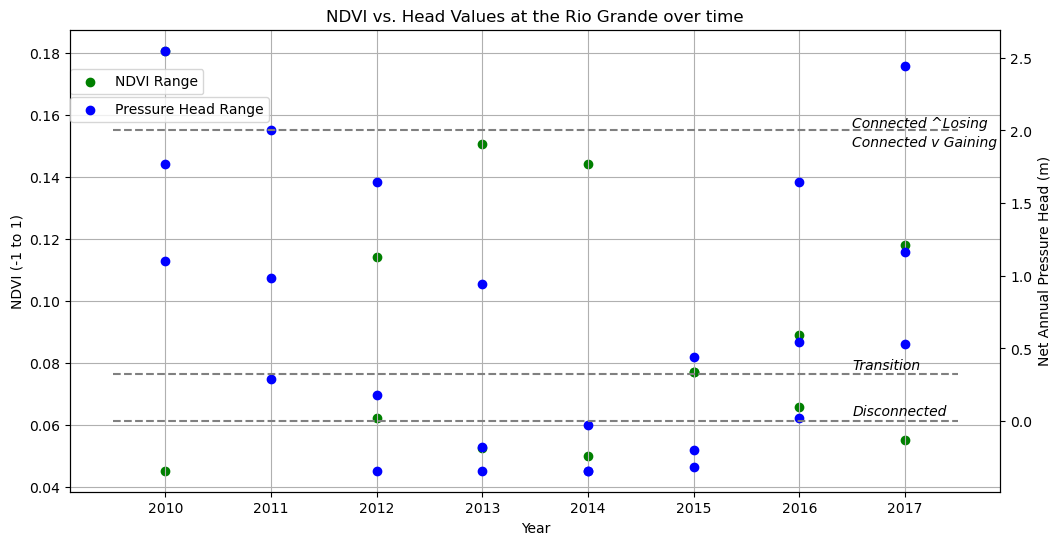

In [216]:
f, ax = plt.subplots(figsize=(12,6))
# ax.scatter(NDVI_ts.index, NDVI_ts[0], color='red')
ax2 = ax.twinx()
ax2.scatter(head_studyareas.index, head_studyareas['Rin_11R'], c='blue', label = 'Pressure Head Range')
ax2.scatter(head_studyareas.index, head_studyareas['Rin_2R'], c='blue')
ax2.scatter(head_studyareas.index, head_studyareas['Rin_12R'], c='blue')
ax.scatter(NDVI_df_year_max.index, NDVI_df_year_max['NDVI'], c='green',label = 'NDVI Range')
ax.scatter(NDVI_df_year_min.index, NDVI_df_year_min['NDVI'], c='green')
ax2.hlines(y=2.0, xmin = 2009.5, xmax = 2017.5,color='grey',linestyles='--')
ax2.hlines(y=0, xmin = 2009.5, xmax = 2017.5,color='grey',linestyles='--')
ax2.hlines(y=0.325, xmin = 2009.5, xmax = 2017.5,color='grey',linestyles='--')
ax.text(2016.5, 0.156, 'Connected ^Losing', style='italic', bbox={
        'facecolor': 'white', 'alpha': 0, 'pad': 5})
ax.text(2016.5, 0.150, 'Connected v Gaining', style='italic', bbox={
        'facecolor': 'white', 'alpha': 0, 'pad': 5})
ax.text(2016.5, 0.078, 'Transition', style='oblique', bbox={
        'facecolor': 'white', 'alpha': 0.0, 'pad': 5})
ax.text(2016.5, 0.063, 'Disconnected', style='oblique', bbox={
        'facecolor': 'white', 'alpha': 0, 'pad': 5})
ax.set(title="NDVI vs. Head Values at the Rio Grande over time")
ax.legend(loc = [0,0.86])
ax2.legend(loc = [0,0.8])
ax.grid(zorder = 0)
ax.set_xlabel('Year')
ax.set_ylabel('NDVI (-1 to 1)')
ax2.set_ylabel('Net Annual Pressure Head (m)')

Text(0, 0.5, 'Seepage Flow (cms)')

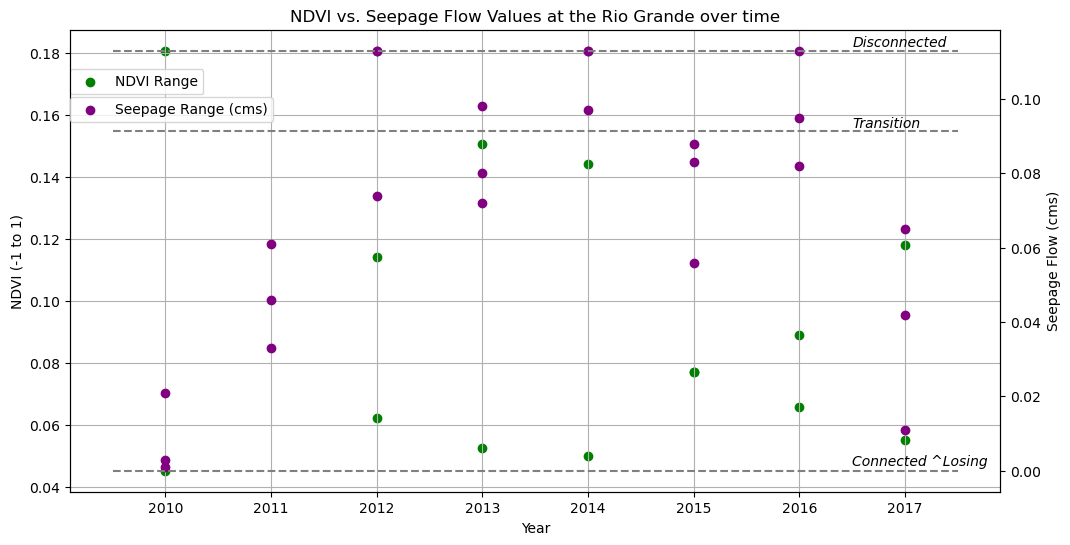

In [210]:
f, ax = plt.subplots(figsize=(12,6))
# ax.scatter(NDVI_ts.index, NDVI_ts[0], color='red')
ax2 = ax.twinx()
ax2.scatter(seepage_studyareas.index, seepage_studyareas['Rin_11R'], c='purple', label = 'Seepage Range (cms)')
ax2.scatter(seepage_studyareas.index, seepage_studyareas['Rin_2R'], c='purple')
ax2.scatter(seepage_studyareas.index, seepage_studyareas['Rin_12R'], c='purple')
ax.scatter(NDVI_df_year_max.index, NDVI_df_year_max['NDVI'], c='green',label = 'NDVI Range')
ax.scatter(NDVI_df_year_min.index, NDVI_df_year_min['NDVI'], c='green')
ax2.hlines(y=0.113, xmin = 2009.5, xmax = 2017.5,color='grey',linestyles='--')
ax2.hlines(y=0, xmin = 2009.5, xmax = 2017.5,color='grey',linestyles='--')
ax2.hlines(y=0.0914, xmin = 2009.5, xmax = 2017.5,color='grey',linestyles='--')
ax.text(2016.5, 0.047, 'Connected ^Losing', style='italic', bbox={
        'facecolor': 'white', 'alpha': 0, 'pad': 5})
ax.text(2016.5, 0.156, 'Transition', style='oblique', bbox={
        'facecolor': 'white', 'alpha': 0.0, 'pad': 5})
ax.text(2016.5, 0.182, 'Disconnected', style='oblique', bbox={
        'facecolor': 'white', 'alpha': 0, 'pad': 5})
# ax.axvspan("2017-06-10T12:00:00.000Z", "2018-06-16T00:00:00.000Z", color='grey', alpha=0.5, lw=0, label="Satellite relaunch gap")
ax.set(title="NDVI vs. Seepage Flow Values at the Rio Grande over time")
ax.legend(loc = [0,0.86])
ax2.legend(loc = [0,0.8])
ax.grid(zorder = 0)
ax.set_xlabel('Year')
ax.set_ylabel('NDVI (-1 to 1)')
ax2.set_ylabel('Seepage Flow (cms)')

In [129]:
NDVI_DF2 = NDVI_df_year_mean.reset_index()
# NDVI_DF2 = NDVI_DF2.append([2011,np.nan])

df = NDVI_DF2.append({'Year':2011, 'NDVI':np.nan}, ignore_index=True)
df

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_3184/3983479622.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = NDVI_DF2.append({'Year':2011, 'NDVI':np.nan}, ignore_index=True)


,Year,NDVI
0,2010.0,0.098050
1,2012.0,0.088233
2,2013.0,0.081068
3,2014.0,0.079872
4,2015.0,0.077225
5,2016.0,0.080045
6,2017.0,0.089396
7,2011.0,NaN


Text(0.5, 0, 'NDVI (-1 to 1)')

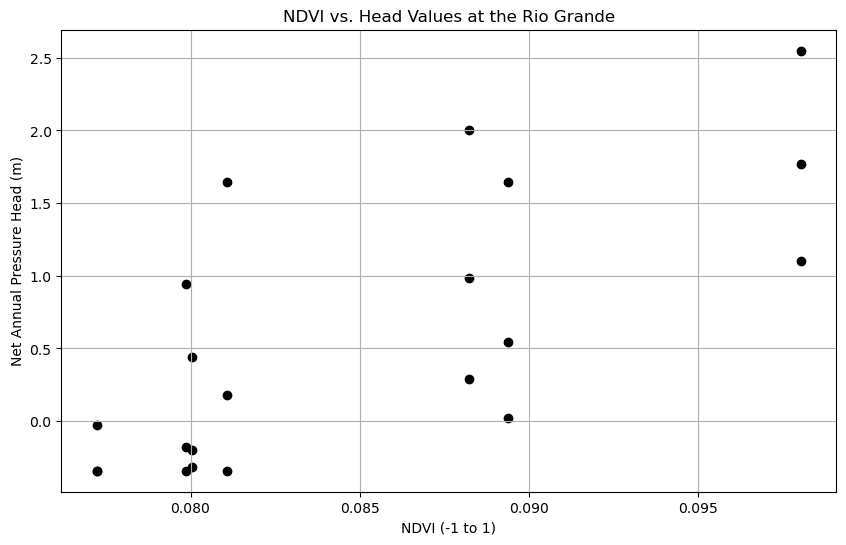

In [152]:
f, ax = plt.subplots(figsize=(10,6))
# ax.scatter(NDVI_ts.index, NDVI_ts[0], color='red')
ax.scatter(df['NDVI'].values, head_studyareas['Rin_11R'].values, c='black',label = 'NDVI Range')
ax.scatter(df['NDVI'].values, head_studyareas['Rin_2R'].values, c='black',label = 'NDVI Range')
ax.scatter(df['NDVI'].values, head_studyareas['Rin_12R'].values, c='black',label = 'NDVI Range')
# ax2.hlines(y=0.113, xmin = 2009.5, xmax = 2017.5,color='grey',linestyles='--')
# ax2.hlines(y=0, xmin = 2009.5, xmax = 2017.5,color='grey',linestyles='--')
# ax2.hlines(y=0.0915, xmin = 2009.5, xmax = 2017.5,color='grey',linestyles='--')
# ax.axvspan("2017-06-10T12:00:00.000Z", "2018-06-16T00:00:00.000Z", color='grey', alpha=0.5, lw=0, label="Satellite relaunch gap")
ax.set(title="NDVI vs. Head Values at the Rio Grande")
# ax.legend(loc = 'lower left')
ax.grid(zorder = 0)
ax.set_ylabel('Net Annual Pressure Head (m)')
ax.set_xlabel('NDVI (-1 to 1)')


In [148]:
# y = seepage_studyareas['Rin_11R'].values
y = seepage_studyareas.iloc[:-1,:]
y

,Rin_11R,Rin_2R,Rin_12R
Year,,,
2010.0,0.021,0.001,0.003
2011.0,0.061,0.046,0.033
2012.0,0.113,0.113,0.074
2013.0,0.098,0.080,0.072
2014.0,0.113,0.097,0.113
2015.0,0.088,0.056,0.083
2016.0,0.113,0.095,0.082
2017.0,0.065,0.042,0.011


Text(0.5, 0, 'NDVI (-1 to 1)')

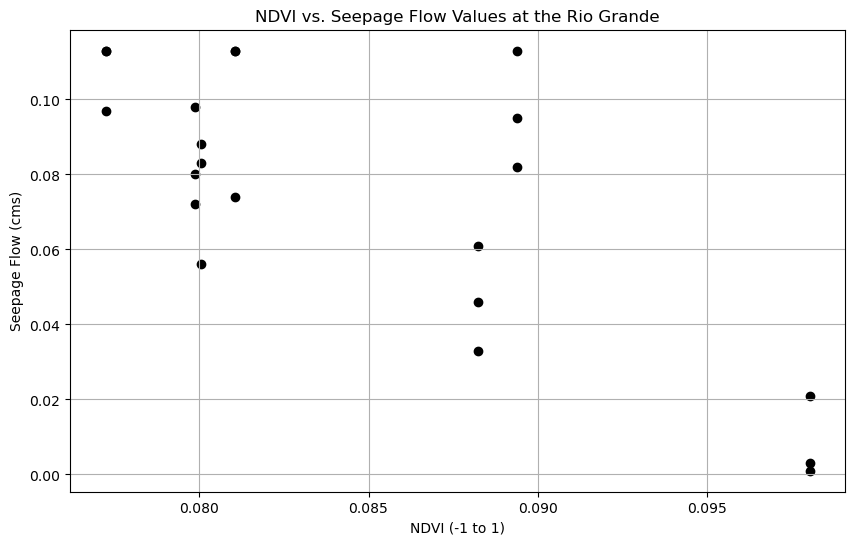

In [151]:
f, ax = plt.subplots(figsize=(10,6))
# ax.scatter(NDVI_ts.index, NDVI_ts[0], color='red')
ax.scatter(df['NDVI'].values, y['Rin_11R'].values, c='black',label = 'NDVI Range')
ax.scatter(df['NDVI'].values, y['Rin_2R'].values, c='black',label = 'NDVI Range')
ax.scatter(df['NDVI'].values, y['Rin_12R'].values, c='black',label = 'NDVI Range')
# ax2.hlines(y=0.113, xmin = 2009.5, xmax = 2017.5,color='grey',linestyles='--')
# ax2.hlines(y=0, xmin = 2009.5, xmax = 2017.5,color='grey',linestyles='--')
# ax2.hlines(y=0.0915, xmin = 2009.5, xmax = 2017.5,color='grey',linestyles='--')
# ax.axvspan("2017-06-10T12:00:00.000Z", "2018-06-16T00:00:00.000Z", color='grey', alpha=0.5, lw=0, label="Satellite relaunch gap")
ax.set(title="NDVI vs. Seepage Flow Values at the Rio Grande")
# ax.legend(loc = 'lower left')
ax.grid(zorder = 0)
ax.set_ylabel('Seepage Flow (cms)')
ax.set_xlabel('NDVI (-1 to 1)')


Failed Code

In [22]:
ndvi3 = data2.transpose('time', 'lat', 'lon')
# ndvi3 = data2
# ndvi3 = ndvi.rio.set_crs("epsg:4326")

ndvi3.rio.set_spatial_dims('lon', 'lat')

<xarray.DataArray 'NDVI' (time: 30, lat: 4990, lon: 3160)>
array([[[       nan,        nan,        nan, ..., 0.04583439,
         0.07864597, 0.06839687],
        [       nan,        nan,        nan, ..., 0.01787394,
         0.05376344, 0.07827039],
        [       nan,        nan,        nan, ..., 0.05179795,
         0.06229661, 0.07583418],
        ...,
        [0.09662751, 0.11536748, 0.12614259, ...,        nan,
                nan,        nan],
        [0.12414109, 0.08584905, 0.10476191, ...,        nan,
                nan,        nan],
        [0.07085916, 0.05160744, 0.04962153, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ..., 0.14185022,
         0.18223584, 0.21866295],
        [       nan,        nan,        nan, ..., 0.16591929,
         0.20993087, 0.2521861 ],
        [       nan,        nan,        nan, ..., 0.16630669,
         0.17650676, 0.20318726],
...
        [0.2570481 , 0.28103682, 0.19244823, ...,        nan,
                nan,        nan],
        [0.11673469, 0.16470589, 0.09968521, ...,        nan,
                nan,        nan],
        [0.08883554, 0.07775965, 0.01830443, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ..., 0.03472222,
         0.06841612, 0.13654473],
        [       nan,        nan,        nan, ..., 0.07624795,
         0.08756039, 0.10951526],
        [       nan,        nan,        nan, ..., 0.07847478,
         0.07059477, 0.05664264],
        ...,
        [0.29340512, 0.24761905, 0.25353926, ...,        nan,
                nan,        nan],
        [0.2766252 , 0.21157822, 0.17713568, ...,        nan,
                nan,        nan],
        [0.24931507, 0.16733068, 0.08290452, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2010-03-25 2010-10-27 ... 2017-11-10
  * lon      (lon) float64 3.611e+06 3.611e+06 3.611e+06 ... 3.627e+06 3.627e+06
  * lat      (lat) float64 2.854e+05 2.854e+05 2.854e+05 ... 3.104e+05 3.104e+05
Attributes:
    description:  Calculated NDVI

In [30]:
# Write an nc file for remapping
ndvi3.rio.to_raster(r"NDVI_time.nc")
# ndvi3.rio.to_raster(r"NDVI_time.tif")
# ndvi3.to_netcdf()

KeyboardInterrupt: 

In [24]:
mask_reproject_easymore = mask.to_crs(epsg=4326)
print("mask crs:", mask_reproject_easymore.crs)

mask crs: EPSG:4326


In [176]:
mask_reproject_easymore.to_file("mask_easymore.shp")
print('file written.')

file written.


<xarray.Variable (band: 1, y: 9422, x: 6984)>
[65803248 values with dtype=float32]
Attributes:
    AREA_OR_POINT:  Area

## Remapping

In [32]:
# Check written ndvi file
filename = 'NDVI_time_attempt2.nc'
ndvi_dataset = xr.open_dataset(filename)
ndvi_dataset

<xarray.Dataset>
Dimensions:  (lat: 3160, lon: 4990)
Coordinates:
  * lat      (lat) float64 3.611e+06 3.611e+06 3.611e+06 ... 3.627e+06 3.627e+06
  * lon      (lon) float64 2.854e+05 2.854e+05 2.854e+05 ... 3.104e+05 3.104e+05
Data variables: (12/30)
    Band1    (lat, lon) float32 ...
    Band2    (lat, lon) float32 ...
    Band3    (lat, lon) float32 ...
    Band4    (lat, lon) float32 ...
    Band5    (lat, lon) float32 ...
    Band6    (lat, lon) float32 ...
    ...       ...
    Band25   (lat, lon) float32 ...
    Band26   (lat, lon) float32 ...
    Band27   (lat, lon) float32 ...
    Band28   (lat, lon) float32 ...
    Band29   (lat, lon) float32 ...
    Band30   (lat, lon) float32 ...
Attributes:
    Conventions:       CF-1.5
    GDAL:              GDAL 3.6.3, released 2023/03/07
    history:           Mon Apr 10 16:30:19 2023: GDAL Create( NDVI_time_attem...
    GDAL_description:  Calculated NDVI

In [25]:
# %% Now remapping following this tutorial
# https://github.com/ShervanGharari/EASYMORE/blob/main/examples/Chapter1_E1.ipynb
# # loading EASYMORE
from easymore.easymore import easymore

# initializing EASYMORE object
esmr = easymore()

# specifying EASYMORE objects
# name of the case; the temporary, remapping and remapped file names include case name
esmr.case_name                = 'ndvi_remapping'              
# temporary path that the EASYMORE generated GIS files and remapped file will be saved
esmr.temp_dir                 = '../temporary/'

# name of target shapefile that the source netcdf files should be remapped to
# It needs me to reproject my shapefile to WGS84 (epsg:4326)
#       Note: It said please
esmr.target_shp = 'mask_easymore.shp'


# name of netCDF file(s); multiple files can be specified with *
esmr.source_nc                = 'NDVI_time.nc'

# name of variables from source netCDF file(s) to be remapped
esmr.var_names                = ["NDVI"]
# rename the variables from source netCDF file(s) in the remapped files;
# it will be the same as source if not provided
esmr.var_names_remapped       = ["NDVI"]
# name of variable longitude in source netCDF files
esmr.var_lon                  = 'lon'
# name of variable latitude in source netCDF files
esmr.var_lat                  = 'lat'
# name of variable time in source netCDF file; should be always time
esmr.var_time                 = 'time'
# location where the remapped netCDF file will be saved
esmr.output_dir               = 'outputfiles/remapped/'
# format of the variables to be saved in remapped files,
# if one format provided it will be expanded to other variables
esmr.format_list              = ['f4']
# fill values of the variables to be saved in remapped files,
# if one value provided it will be expanded to other variables
esmr.fill_value_list          = ['-9999.00']
# if required that the remapped values to be saved as csv as well
esmr.save_csv                 = True
esmr.complevel                 =  9
# if uncommented EASYMORE will use this and skip GIS tasks
#esmr.remap_csv                = '../temporary/ERA5_Medicine_Hat_remapping.csv'

EASYMORE version 0.0.4 is initiated.


In [26]:
# execute EASYMORE
esmr.nc_remapper()

no author name is provide and the author name is changed to (author name)!
EASYMORE will remap variable  NDVI  from source file to variable  NDVI  in remapped NeCDF file
EASYMORE detects that target shapefile is in WGS84 (epsg:4326)
EASYMORE detects that no field for ID is provided in sink/target shapefile
arbitarary values of ID are added in the field ID_t
EASYMORE detects that either of the fields for latitude or longitude is not provided in sink/target shapefile
calculating centroid of shapes in WGS84 projection;
for better appximation use the easymore equal area centroid function to preprocess target shapefile
EASYMORE detects that no field for latitude is provided in sink/target shapefile
latitude values are added in the field lat_t
EASYMORE detects that no field for longitude is provided in sink/target shapefile
longitude values are added in the field lon_t
it seems everything is OK with the sink/target shapefile; added to EASYMORE object target_shp_gpd
EASYMORE will save standar

KeyError: 'NDVI'